In [21]:
# Import Required Libraries
import os
import glob
import gc
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn imports
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, 
    f1_score, balanced_accuracy_score, precision_score, recall_score
)
from scipy.stats import mode

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Libraries imported successfully
NumPy version: 2.3.4
Pandas version: 2.3.3


## Configuration

In [22]:
# Configuration - Same as Deep Learning Models
DATA_DIR = r'c:\Users\sande\programs\data'
MODEL_SAVE_PATH = 'clustering_baseline_model.pkl'
LOG_FILE = f'clustering_baseline_log_{datetime.now().strftime("%Y%m%d_%H%M%S")}.txt'

# Clustering Parameters
N_CLUSTERS = 34  # Match number of attack classes
BATCH_SIZE = 10000  # Mini-batch size for incremental learning
MAX_ITERATIONS = 300  # K-Means iterations
N_INIT = 10  # Number of random initializations

# Memory Optimization - Same as Deep Learning
CHUNK_SIZE = 50000  # Same chunk size as AE-xLSTM-CNN
N_JOBS = -1  # Use all CPU cores

# Evaluation
TEST_SPLIT = 0.2  # 80/20 train/val split

print(f"Configuration:")
print(f"  Number of Clusters: {N_CLUSTERS}")
print(f"  Batch Size: {BATCH_SIZE:,}")
print(f"  Chunk Size: {CHUNK_SIZE:,}")
print(f"  Max Iterations: {MAX_ITERATIONS}")
print(f"  CPU Cores: All available")
print(f"  Log File: {LOG_FILE}")

Configuration:
  Number of Clusters: 34
  Batch Size: 10,000
  Chunk Size: 50,000
  Max Iterations: 300
  CPU Cores: All available
  Log File: clustering_baseline_log_20251128_234037.txt


In [23]:
# Get all CSV files
csv_files = sorted(glob.glob(os.path.join(DATA_DIR, '*.csv')))
csv_files = [f for f in csv_files if 'Zone.Identifier' not in f]

print(f"Found {len(csv_files)} CSV files in {DATA_DIR}")
print(f"\nFirst 5 files:")
for i, file in enumerate(csv_files[:5]):
    file_size = os.path.getsize(file) / (1024**2)
    print(f"  {i+1}. {os.path.basename(file)} ({file_size:.2f} MB)")
    
if len(csv_files) > 5:
    print(f"  ... and {len(csv_files) - 5} more files")

# Calculate total dataset size
total_size_gb = sum(os.path.getsize(f) for f in csv_files) / (1024**3)
print(f"\nTotal dataset size: {total_size_gb:.2f} GB")

Found 169 CSV files in c:\Users\sande\programs\data

First 5 files:
  1. part-00000-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv (67.08 MB)
  2. part-00001-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv (61.49 MB)
  3. part-00002-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv (77.34 MB)
  4. part-00003-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv (64.90 MB)
  5. part-00004-363d1ba3-8ab5-4f96-bc25-4d5862db7cb9-c000.csv (63.90 MB)
  ... and 164 more files

Total dataset size: 12.81 GB


## Data Preprocessing - Same as Deep Learning Models

In [24]:
# Peek at first file
sample_df = pd.read_csv(csv_files[0], nrows=1000)
print(f"Dataset shape (sample): {sample_df.shape}")
print(f"\nColumns ({len(sample_df.columns)}):")
print(sample_df.columns.tolist())
print(f"\nLabel distribution (sample):")
print(sample_df['label'].value_counts())
print(f"\nData types:")
print(sample_df.dtypes.value_counts())

Dataset shape (sample): (1000, 47)

Columns (47):
['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight', 'label']

Label distribution (sample):
label
DDoS-ICMP_Flood            142
DDoS-UDP_Flood             106
DDoS-TCP_Flood              96
DDoS-PSHACK_Flood           95
DDoS-RSTFINFlood            94
DDoS-SynonymousIP_Flood     94
DoS-UDP_Flood               75
DDoS-SYN_Flood              66
DoS-TCP_Flood               58
DoS-SYN_Flood               53
BenignTraffic               26
Mirai-greeth_flood          24
Mirai-udppla

In [25]:
# Fit global label encoder and scaler (same as deep learning)
global_label_encoder = LabelEncoder()
global_scaler = StandardScaler()

print("Fitting global label encoder and scaler...")
all_labels = []
feature_samples = []

for file in tqdm(csv_files[:20], desc="Sampling files"):
    try:
        df_sample = pd.read_csv(file, nrows=5000)
        if 'label' in df_sample.columns:
            all_labels.extend(df_sample['label'].unique())
            
            feature_cols = [col for col in df_sample.columns if col != 'label']
            X_sample = df_sample[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0)
            feature_samples.append(X_sample)
    except Exception as e:
        print(f"Error sampling {file}: {e}")
        continue

# Fit encoders
all_labels = list(set(all_labels))
global_label_encoder.fit(all_labels)
print(f"\nFound {len(all_labels)} unique labels")
print(f"Labels: {all_labels}")

# Fit scaler
combined_features = pd.concat(feature_samples, ignore_index=True)
global_scaler.fit(combined_features)
print(f"Scaler fitted on {len(combined_features):,} samples")

NUM_CLASSES = len(all_labels)
NUM_FEATURES = len(combined_features.columns)
print(f"\nNum Features: {NUM_FEATURES}")
print(f"Num Classes: {NUM_CLASSES}")

del feature_samples, combined_features, df_sample, X_sample
gc.collect()

Fitting global label encoder and scaler...


Sampling files: 100%|██████████| 20/20 [00:00<00:00, 52.33it/s]




Found 34 unique labels
Labels: ['Recon-PingSweep', 'DDoS-TCP_Flood', 'DoS-TCP_Flood', 'DDoS-PSHACK_Flood', 'DNS_Spoofing', 'DDoS-ICMP_Fragmentation', 'DoS-SYN_Flood', 'Recon-OSScan', 'VulnerabilityScan', 'DDoS-SlowLoris', 'DDoS-RSTFINFlood', 'Mirai-greeth_flood', 'DDoS-UDP_Flood', 'Mirai-greip_flood', 'DDoS-SynonymousIP_Flood', 'DDoS-HTTP_Flood', 'DoS-UDP_Flood', 'BenignTraffic', 'MITM-ArpSpoofing', 'DDoS-UDP_Fragmentation', 'DoS-HTTP_Flood', 'DDoS-ICMP_Flood', 'CommandInjection', 'DDoS-SYN_Flood', 'Mirai-udpplain', 'Uploading_Attack', 'BrowserHijacking', 'SqlInjection', 'Backdoor_Malware', 'DDoS-ACK_Fragmentation', 'Recon-PortScan', 'Recon-HostDiscovery', 'XSS', 'DictionaryBruteForce']
Scaler fitted on 100,000 samples

Num Features: 46
Num Classes: 34


155884

In [26]:
# Check class distribution
print("\nAnalyzing class distribution across dataset...")
all_labels_sample = []
for file in tqdm(csv_files[:20], desc="Sampling for class distribution"):
    try:
        df = pd.read_csv(file, usecols=['label'], nrows=10000)
        all_labels_sample.extend(df['label'].values)
    except:
        continue

label_counts = pd.Series(all_labels_sample).value_counts()
print(f"\nClass distribution (top 10):")
print(label_counts.head(10))
print(f"\nMost common class: {label_counts.iloc[0] / len(all_labels_sample) * 100:.1f}%")
print(f"Least common class: {label_counts.iloc[-1] / len(all_labels_sample) * 100:.2f}%")
print(f"\nClass imbalance ratio: {label_counts.iloc[0] / label_counts.iloc[-1]:.1f}:1")
print(f"\n⚠️ Warning: Clustering struggles with severe class imbalance!")


Analyzing class distribution across dataset...


Sampling for class distribution: 100%|██████████| 20/20 [00:00<00:00, 46.89it/s]


Class distribution (top 10):
DDoS-ICMP_Flood            30942
DDoS-UDP_Flood             23057
DDoS-TCP_Flood             19380
DDoS-PSHACK_Flood          17565
DDoS-SYN_Flood             17317
DDoS-RSTFINFlood           17300
DDoS-SynonymousIP_Flood    15524
DoS-UDP_Flood              14216
DoS-TCP_Flood              11299
DoS-SYN_Flood               8763
Name: count, dtype: int64

Most common class: 15.5%
Least common class: 0.00%

Class imbalance ratio: 5157.0:1

⚠️ Warning: Clustering struggles with severe class imbalance!


In [27]:
# Use ALL files for clustering (unsupervised learning doesn't need train/val split)
print(f"Using ALL {len(csv_files)} files for clustering training")
print("Reason: Clustering is unsupervised - more data = better cluster centers")
print("\nAfter clustering, we'll evaluate on the same data to get metrics.")

Using ALL 169 files for clustering training
Reason: Clustering is unsupervised - more data = better cluster centers

After clustering, we'll evaluate on the same data to get metrics.


## Mini-Batch K-Means Clustering

Using Mini-Batch K-Means for memory efficiency with large datasets

In [28]:
# Initialize Mini-Batch K-Means
print("Initializing Mini-Batch K-Means...")
clustering_model = MiniBatchKMeans(
    n_clusters=N_CLUSTERS,
    batch_size=BATCH_SIZE,
    max_iter=MAX_ITERATIONS,
    n_init=N_INIT,
    random_state=42,
    verbose=1
)

print(f"\nModel Configuration:")
print(f"  Algorithm: Mini-Batch K-Means")
print(f"  Number of Clusters: {N_CLUSTERS}")
print(f"  Batch Size: {BATCH_SIZE:,}")
print(f"  Max Iterations: {MAX_ITERATIONS}")
print(f"  Random Initializations: {N_INIT}")

Initializing Mini-Batch K-Means...

Model Configuration:
  Algorithm: Mini-Batch K-Means
  Number of Clusters: 34
  Batch Size: 10,000
  Max Iterations: 300
  Random Initializations: 10


## Training Phase - Incremental Learning

In [29]:
# Training with file-by-file streaming
print("\n" + "="*70)
print("Starting Clustering Training (Incremental Mini-Batch)")
print("="*70)

training_start_time = time.time()
total_samples_trained = 0
file_count = 0

log_messages = []
log_messages.append(f"Training started at {datetime.now()}")
log_messages.append(f"Configuration: Clusters={N_CLUSTERS}, Batch={BATCH_SIZE}, Chunk={CHUNK_SIZE}")
log_messages.append("="*70)

for train_file in tqdm(csv_files, desc="Training on files"):
    try:
        chunk_iterator = pd.read_csv(train_file, chunksize=CHUNK_SIZE)
        
        for chunk_df in chunk_iterator:
            if 'label' not in chunk_df.columns:
                continue
            
            # Extract features
            feature_cols = [col for col in chunk_df.columns if col != 'label']
            X = chunk_df[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0).values
            
            if len(X) == 0:
                continue
            
            # Scale features
            X_scaled = global_scaler.transform(X)
            
            # Partial fit (incremental learning)
            clustering_model.partial_fit(X_scaled)
            total_samples_trained += len(X_scaled)
            
            del X, X_scaled
            gc.collect()
        
        file_count += 1
        
        # Progress update every 10 files
        if file_count % 10 == 0:
            elapsed = time.time() - training_start_time
            samples_per_sec = total_samples_trained / elapsed
            msg = f"  Files: {file_count}/{len(csv_files)} | Samples: {total_samples_trained:,} | Throughput: {samples_per_sec:.0f} samples/sec"
            print(msg)
            log_messages.append(msg)
            
    except Exception as e:
        error_msg = f"Error processing {train_file}: {e}"
        print(error_msg)
        log_messages.append(error_msg)
        continue

training_time = time.time() - training_start_time

print("\n" + "="*70)
print(f"Training Complete!")
print(f"  Total Training Time: {training_time:.1f} seconds ({training_time/60:.1f} minutes)")
print(f"  Total Samples Trained: {total_samples_trained:,}")
print(f"  Average Throughput: {total_samples_trained/training_time:.0f} samples/sec")
print(f"  Cluster Centers Shape: {clustering_model.cluster_centers_.shape}")
print(f"  Inertia: {clustering_model.inertia_:.2f}")
print("="*70)

log_messages.append(f"\nTraining completed in {training_time:.1f} seconds")
log_messages.append(f"Total samples: {total_samples_trained:,}")
log_messages.append(f"Inertia: {clustering_model.inertia_:.2f}")


Starting Clustering Training (Incremental Mini-Batch)


Training on files:   0%|          | 0/169 [00:00<?, ?it/s]

[MiniBatchKMeans] Reassigning 11 cluster centers.


Training on files:   2%|▏         | 4/169 [00:11<08:09,  2.97s/it]

[MiniBatchKMeans] Reassigning 1 cluster centers.


Training on files:   6%|▌         | 10/169 [00:32<09:12,  3.48s/it]

  Files: 10/169 | Samples: 2,366,956 | Throughput: 73646 samples/sec


Training on files:  12%|█▏        | 20/169 [00:59<06:50,  2.75s/it]

  Files: 20/169 | Samples: 4,723,822 | Throughput: 78900 samples/sec


Training on files:  18%|█▊        | 30/169 [01:31<07:15,  3.13s/it]

  Files: 30/169 | Samples: 7,332,065 | Throughput: 80317 samples/sec


Training on files:  24%|██▎       | 40/169 [02:05<08:04,  3.76s/it]

  Files: 40/169 | Samples: 10,287,724 | Throughput: 81832 samples/sec


Training on files:  30%|██▉       | 50/169 [02:38<06:06,  3.08s/it]

  Files: 50/169 | Samples: 12,859,545 | Throughput: 81053 samples/sec


Training on files:  36%|███▌      | 60/169 [03:14<06:01,  3.32s/it]

  Files: 60/169 | Samples: 15,637,929 | Throughput: 80520 samples/sec


Training on files:  41%|████▏     | 70/169 [03:50<05:38,  3.42s/it]

  Files: 70/169 | Samples: 18,266,470 | Throughput: 79167 samples/sec


Training on files:  47%|████▋     | 80/169 [04:32<07:20,  4.95s/it]

  Files: 80/169 | Samples: 21,730,116 | Throughput: 79754 samples/sec


Training on files:  53%|█████▎    | 90/169 [05:00<03:46,  2.86s/it]

  Files: 90/169 | Samples: 24,071,871 | Throughput: 80071 samples/sec


Training on files:  59%|█████▉    | 100/169 [05:37<04:12,  3.66s/it]

  Files: 100/169 | Samples: 27,099,440 | Throughput: 80264 samples/sec


Training on files:  65%|██████▌   | 110/169 [06:08<03:10,  3.23s/it]

  Files: 110/169 | Samples: 29,467,740 | Throughput: 80058 samples/sec


Training on files:  71%|███████   | 120/169 [06:40<02:22,  2.92s/it]

  Files: 120/169 | Samples: 32,085,601 | Throughput: 80109 samples/sec


Training on files:  77%|███████▋  | 130/169 [07:13<02:10,  3.36s/it]

  Files: 130/169 | Samples: 34,921,131 | Throughput: 80579 samples/sec


Training on files:  83%|████████▎ | 140/169 [07:49<01:45,  3.64s/it]

  Files: 140/169 | Samples: 37,975,764 | Throughput: 80881 samples/sec


Training on files:  89%|████████▉ | 150/169 [08:25<01:11,  3.76s/it]

  Files: 150/169 | Samples: 40,982,360 | Throughput: 81110 samples/sec


Training on files:  95%|█████████▍| 160/169 [08:59<00:28,  3.15s/it]

  Files: 160/169 | Samples: 43,746,132 | Throughput: 81117 samples/sec


Training on files: 100%|██████████| 169/169 [09:33<00:00,  3.39s/it]


Training Complete!
  Total Training Time: 573.6 seconds (9.6 minutes)
  Total Samples Trained: 46,686,579
  Average Throughput: 81388 samples/sec
  Cluster Centers Shape: (34, 46)
  Inertia: 408469.51


## Cluster-to-Class Mapping

Map each cluster to the most common attack class (majority voting)

In [30]:
# Build cluster-to-class mapping using training data
print("\nBuilding cluster-to-class mapping (majority voting)...")

cluster_to_class_votes = {i: [] for i in range(N_CLUSTERS)}
mapping_samples = 0

for train_file in tqdm(csv_files[:100], desc="Mapping clusters"):  # Use large subset for accurate mapping
    try:
        chunk_iterator = pd.read_csv(train_file, chunksize=CHUNK_SIZE)
        
        for chunk_df in chunk_iterator:
            if 'label' not in chunk_df.columns:
                continue
            
            feature_cols = [col for col in chunk_df.columns if col != 'label']
            X = chunk_df[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0).values
            y_raw = chunk_df['label'].values
            
            # Handle unseen labels
            mask = np.isin(y_raw, global_label_encoder.classes_)
            X = X[mask]
            y_raw = y_raw[mask]
            
            if len(X) == 0:
                continue
            
            X_scaled = global_scaler.transform(X)
            y_encoded = global_label_encoder.transform(y_raw)
            
            # Predict clusters
            cluster_predictions = clustering_model.predict(X_scaled)
            
            # Vote for each cluster
            for cluster_id, true_label in zip(cluster_predictions, y_encoded):
                cluster_to_class_votes[cluster_id].append(true_label)
            
            mapping_samples += len(X_scaled)
            
            del X, X_scaled, y_raw, y_encoded
            gc.collect()
            
    except Exception as e:
        print(f"Error in mapping: {e}")
        continue

# Assign most common class to each cluster
cluster_to_class_map = {}
for cluster_id, votes in cluster_to_class_votes.items():
    if len(votes) > 0:
        most_common_class = mode(votes, keepdims=True)[0][0]
        cluster_to_class_map[cluster_id] = most_common_class
    else:
        # No votes: assign to most common class overall
        cluster_to_class_map[cluster_id] = 0  # Default

print(f"\nMapping complete using {mapping_samples:,} samples")
print(f"Cluster-to-Class assignments:")
for cluster_id in range(min(10, N_CLUSTERS)):  # Show first 10
    assigned_class = cluster_to_class_map[cluster_id]
    class_name = global_label_encoder.classes_[assigned_class]
    vote_count = len(cluster_to_class_votes[cluster_id])
    print(f"  Cluster {cluster_id} → {class_name} ({vote_count:,} votes)")

if N_CLUSTERS > 10:
    print(f"  ... and {N_CLUSTERS - 10} more clusters")


Building cluster-to-class mapping (majority voting)...


Mapping clusters: 100%|██████████| 100/100 [05:44<00:00,  3.44s/it]




Mapping complete using 27,099,440 samples
Cluster-to-Class assignments:
  Cluster 0 → DDoS-ICMP_Flood (444,899 votes)
  Cluster 1 → DDoS-RSTFINFlood (2,320,689 votes)
  Cluster 2 → DDoS-UDP_Flood (1,000,472 votes)
  Cluster 3 → BenignTraffic (96,344 votes)
  Cluster 4 → DDoS-ICMP_Fragmentation (254,224 votes)
  Cluster 5 → DDoS-SynonymousIP_Flood (1,374,236 votes)
  Cluster 6 → DDoS-PSHACK_Flood (279,365 votes)
  Cluster 7 → DoS-SYN_Flood (93,729 votes)
  Cluster 8 → DDoS-UDP_Fragmentation (371,962 votes)
  Cluster 9 → Mirai-greeth_flood (991,695 votes)
  ... and 24 more clusters


## Validation Phase - Performance Evaluation

In [31]:
# Evaluate on ALL data (same data used for clustering)
print("\n" + "="*70)
print("Evaluation Phase - Measuring Clustering Quality on Full Dataset")
print("="*70)

all_predictions = []
all_labels = []
eval_samples = 0

evaluation_start_time = time.time()

for file in tqdm(csv_files, desc="Evaluating on all files"):
    try:
        chunk_iterator = pd.read_csv(file, chunksize=CHUNK_SIZE)
        
        for chunk_df in chunk_iterator:
            if 'label' not in chunk_df.columns:
                continue
            
            feature_cols = [col for col in chunk_df.columns if col != 'label']
            X = chunk_df[feature_cols].replace([np.inf, -np.inf], np.nan).fillna(0).values
            y_raw = chunk_df['label'].values
            
            # Handle unseen labels
            mask = np.isin(y_raw, global_label_encoder.classes_)
            X = X[mask]
            y_raw = y_raw[mask]
            
            if len(X) == 0:
                continue
            
            X_scaled = global_scaler.transform(X)
            y_encoded = global_label_encoder.transform(y_raw)
            
            # Predict clusters, then map to classes
            cluster_predictions = clustering_model.predict(X_scaled)
            class_predictions = np.array([cluster_to_class_map[c] for c in cluster_predictions])
            
            all_predictions.extend(class_predictions)
            all_labels.extend(y_encoded)
            eval_samples += len(X_scaled)
            
            del X, X_scaled, y_raw, y_encoded
            gc.collect()
            
    except Exception as e:
        print(f"Error in evaluation: {e}")
        continue

evaluation_time = time.time() - evaluation_start_time

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

print(f"\nEvaluation completed in {evaluation_time:.1f} seconds")
print(f"Total evaluation samples: {eval_samples:,}")


Evaluation Phase - Measuring Clustering Quality on Full Dataset


Evaluating on all files: 100%|██████████| 169/169 [18:16<00:00,  6.49s/it]




Evaluation completed in 1096.4 seconds
Total evaluation samples: 46,686,579


## Performance Metrics - Comprehensive Evaluation

In [32]:
# Calculate all performance metrics
print("\n" + "="*70)
print("PERFORMANCE METRICS - CLUSTERING BASELINE")
print("="*70)

# Overall metrics
accuracy = accuracy_score(all_labels, all_predictions)
balanced_acc = balanced_accuracy_score(all_labels, all_predictions)
macro_f1 = f1_score(all_labels, all_predictions, average='macro', zero_division=0)
weighted_f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)
macro_precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
macro_recall = recall_score(all_labels, all_predictions, average='macro', zero_division=0)

print(f"\n📊 Overall Performance:")
print(f"  Accuracy:           {accuracy*100:.2f}%")
print(f"  Balanced Accuracy:  {balanced_acc*100:.2f}%")
print(f"  Macro F1-Score:     {macro_f1*100:.2f}%")
print(f"  Weighted F1-Score:  {weighted_f1*100:.2f}%")
print(f"  Macro Precision:    {macro_precision*100:.2f}%")
print(f"  Macro Recall:       {macro_recall*100:.2f}%")

print(f"\n⏱️ Performance:")
print(f"  Training Time:      {training_time:.1f}s ({training_time/60:.1f} min)")
print(f"  Evaluation Time:    {evaluation_time:.1f}s")
print(f"  Training Throughput: {total_samples_trained/training_time:.0f} samples/sec")
print(f"  Evaluation Throughput: {eval_samples/evaluation_time:.0f} samples/sec")

# Save to log
log_messages.append("\n" + "="*70)
log_messages.append("VALIDATION RESULTS")
log_messages.append("="*70)
log_messages.append(f"Accuracy: {accuracy*100:.2f}%")
log_messages.append(f"Balanced Accuracy: {balanced_acc*100:.2f}%")
log_messages.append(f"Macro F1: {macro_f1*100:.2f}%")
log_messages.append(f"Weighted F1: {weighted_f1*100:.2f}%")


PERFORMANCE METRICS - CLUSTERING BASELINE

📊 Overall Performance:
  Accuracy:           74.92%
  Balanced Accuracy:  35.92%
  Macro F1-Score:     31.05%
  Weighted F1-Score:  68.68%
  Macro Precision:    31.14%
  Macro Recall:       35.92%

⏱️ Performance:
  Training Time:      573.6s (9.6 min)
  Evaluation Time:    1096.4s
  Training Throughput: 81388 samples/sec
  Evaluation Throughput: 42580 samples/sec

📊 Overall Performance:
  Accuracy:           74.92%
  Balanced Accuracy:  35.92%
  Macro F1-Score:     31.05%
  Weighted F1-Score:  68.68%
  Macro Precision:    31.14%
  Macro Recall:       35.92%

⏱️ Performance:
  Training Time:      573.6s (9.6 min)
  Evaluation Time:    1096.4s
  Training Throughput: 81388 samples/sec
  Evaluation Throughput: 42580 samples/sec


In [33]:
# Calculate confusion matrix
cm = confusion_matrix(all_val_labels, all_val_predictions)

# Per-class TP, FP, FN, TN
num_classes = len(global_label_encoder.classes_)
tp_per_class = np.diag(cm)
fp_per_class = cm.sum(axis=0) - tp_per_class
fn_per_class = cm.sum(axis=1) - tp_per_class
tn_per_class = cm.sum() - (tp_per_class + fp_per_class + fn_per_class)

print("\n" + "="*80)
print("PER-CLASS METRICS (TP, FP, FN, TN)")
print("="*80)
print(f"{'Class':<30} {'TP':>8} {'FP':>8} {'FN':>8} {'TN':>8} {'Precision':>10} {'Recall':>10}")
print("-"*80)

for i, class_name in enumerate(global_label_encoder.classes_):
    precision = tp_per_class[i] / (tp_per_class[i] + fp_per_class[i]) if (tp_per_class[i] + fp_per_class[i]) > 0 else 0
    recall = tp_per_class[i] / (tp_per_class[i] + fn_per_class[i]) if (tp_per_class[i] + fn_per_class[i]) > 0 else 0
    print(f"{class_name:<30} {tp_per_class[i]:>8} {fp_per_class[i]:>8} {fn_per_class[i]:>8} {tn_per_class[i]:>8} {precision:>10.2%} {recall:>10.2%}")

# Overall
total_tp = tp_per_class.sum()
total_fp = fp_per_class.sum()
total_fn = fn_per_class.sum()
total_tn = tn_per_class.sum()

print("-"*80)
print(f"{'OVERALL':<30} {total_tp:>8} {total_fp:>8} {total_fn:>8} {total_tn:>8}")
print("="*80)


PER-CLASS METRICS (TP, FP, FN, TN)
Class                                TP       FP       FN       TN  Precision     Recall
--------------------------------------------------------------------------------
Backdoor_Malware                      0        0      649  9564982      0.00%      0.00%
BenignTraffic                    220239   161084     4479  9179829     57.76%     98.01%
BrowserHijacking                      0        0     1129  9564502      0.00%      0.00%
CommandInjection                      0        0     1075  9564556      0.00%      0.00%
DDoS-ACK_Fragmentation                0        0    58328  9507303      0.00%      0.00%
DDoS-HTTP_Flood                       0        0     5886  9559745      0.00%      0.00%
DDoS-ICMP_Flood                 1468772     9949     7482  8079428     99.33%     99.49%
DDoS-ICMP_Fragmentation           89750       81     2795  9473005     99.91%     96.98%
DDoS-PSHACK_Flood                827596    20470    10488  8707077     97.59%     

In [34]:
# Detailed classification report
print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORT")
print("="*80)
report = classification_report(
    all_val_labels, all_val_predictions,
    target_names=global_label_encoder.classes_,
    zero_division=0,
    digits=4
)
print(report)

log_messages.append("\n" + "="*70)
log_messages.append("CLASSIFICATION REPORT")
log_messages.append("="*70)
log_messages.append(report)


DETAILED CLASSIFICATION REPORT
                         precision    recall  f1-score   support

       Backdoor_Malware     0.0000    0.0000    0.0000       649
          BenignTraffic     0.5776    0.9801    0.7268    224718
       BrowserHijacking     0.0000    0.0000    0.0000      1129
       CommandInjection     0.0000    0.0000    0.0000      1075
 DDoS-ACK_Fragmentation     0.0000    0.0000    0.0000     58328
        DDoS-HTTP_Flood     0.0000    0.0000    0.0000      5886
        DDoS-ICMP_Flood     0.9933    0.9949    0.9941   1476254
DDoS-ICMP_Fragmentation     0.9991    0.9698    0.9842     92545
      DDoS-PSHACK_Flood     0.9759    0.9875    0.9816    838084
       DDoS-RSTFINFlood     0.9670    0.9969    0.9817    829319
         DDoS-SYN_Flood     0.5928    0.9183    0.7205    831497
         DDoS-SlowLoris     0.0000    0.0000    0.0000      4794
DDoS-SynonymousIP_Flood     0.5672    0.5789    0.5730    736958
         DDoS-TCP_Flood     0.6334    0.9648    0.7647   

## Confusion Matrix Visualization

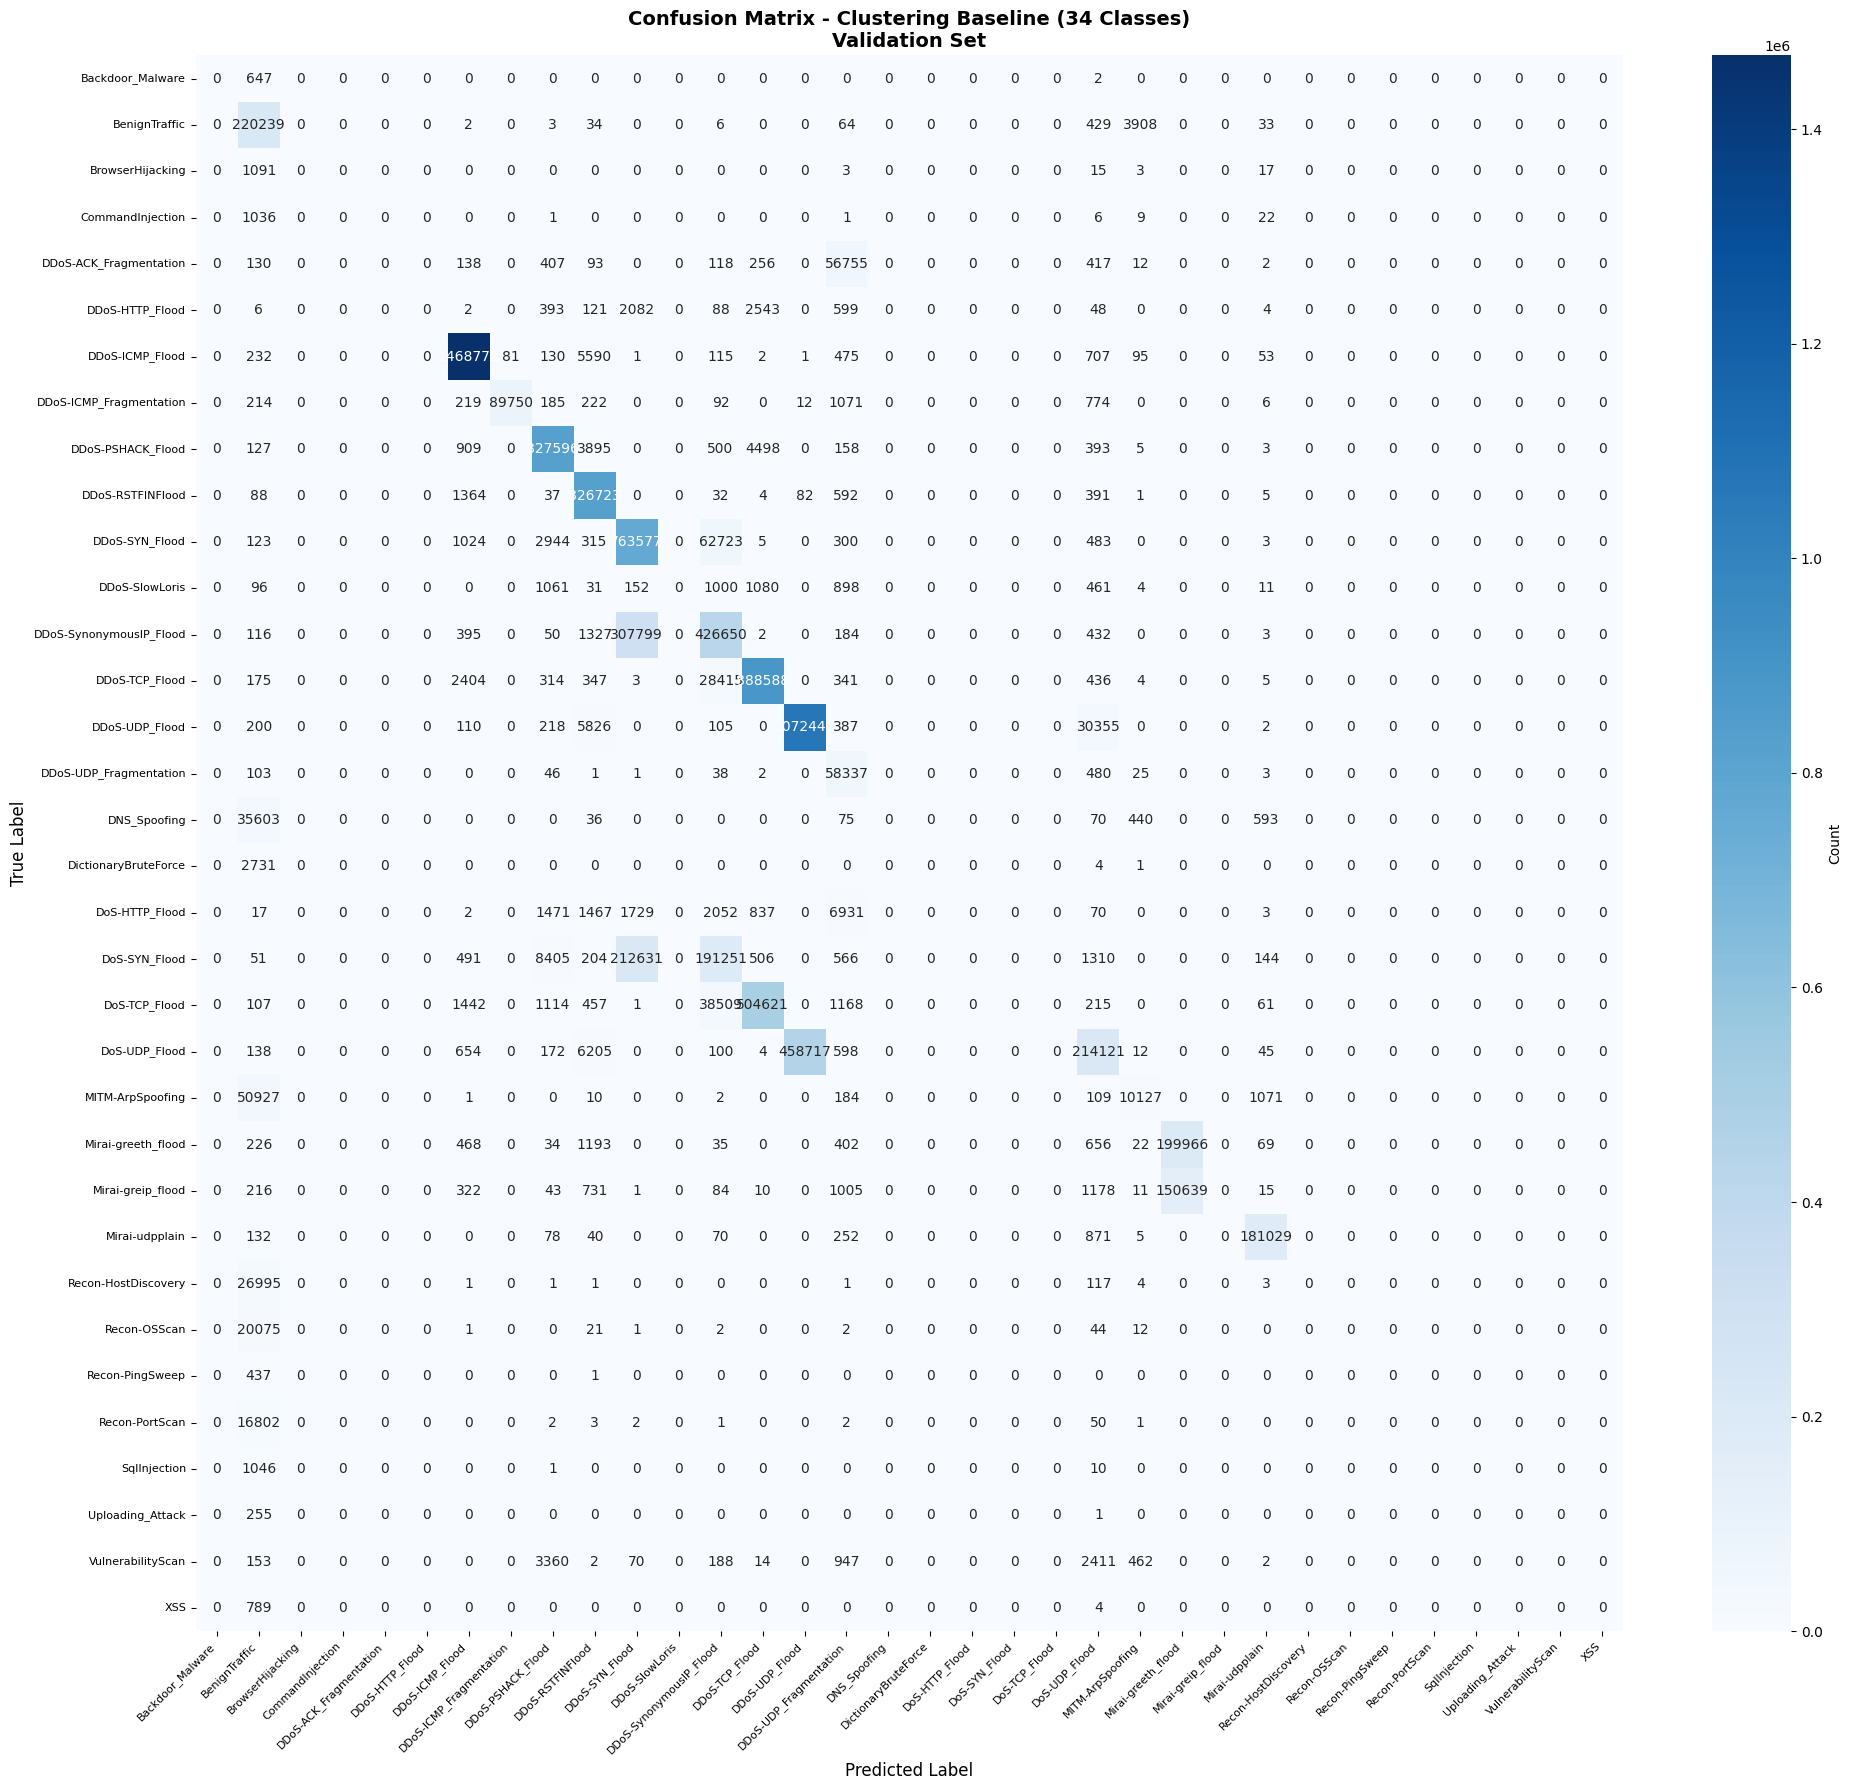

Confusion matrix saved as 'confusion_matrix_clustering_baseline.png'


In [35]:
# Plot confusion matrix (raw counts)
plt.figure(figsize=(20, 18))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=global_label_encoder.classes_,
            yticklabels=global_label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title(f'Confusion Matrix - Clustering Baseline ({num_classes} Classes)\nValidation Set', 
          fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig('confusion_matrix_clustering_baseline.png', dpi=300, bbox_inches='tight')
plt.show()

print("Confusion matrix saved as 'confusion_matrix_clustering_baseline.png'")

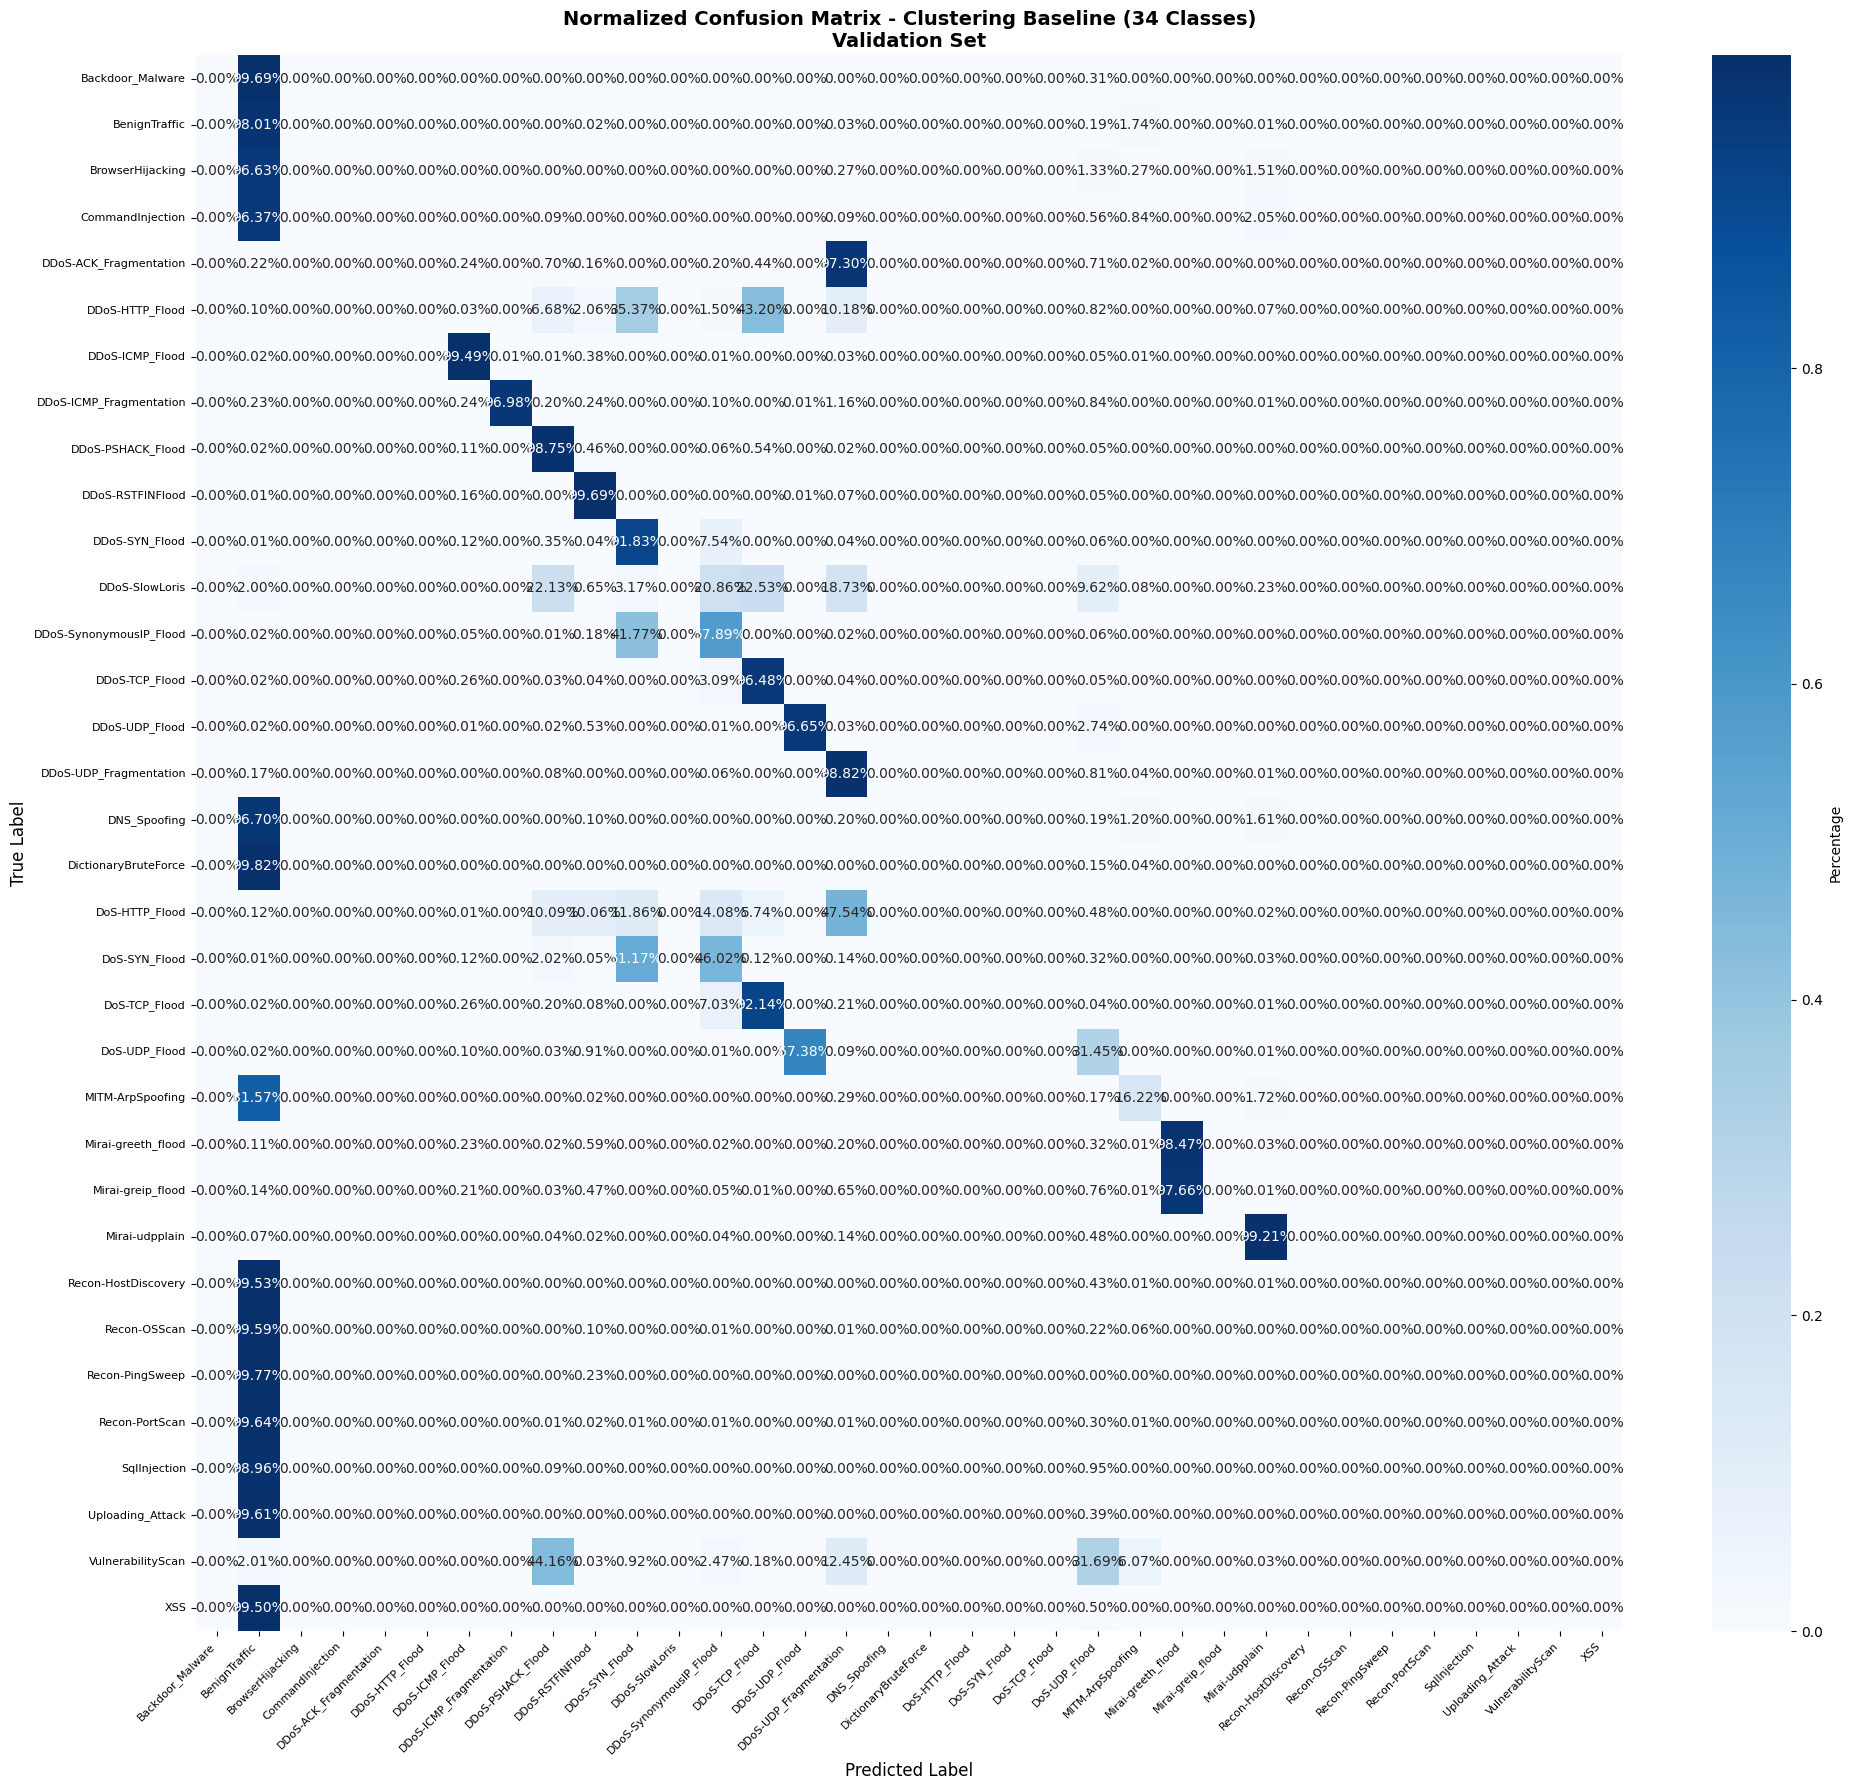

Normalized confusion matrix saved as 'confusion_matrix_clustering_normalized.png'


In [36]:
# Plot normalized confusion matrix (percentages)
plt.figure(figsize=(20, 18))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized = np.nan_to_num(cm_normalized)  # Handle division by zero

sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=global_label_encoder.classes_,
            yticklabels=global_label_encoder.classes_,
            cbar_kws={'label': 'Percentage'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title(f'Normalized Confusion Matrix - Clustering Baseline ({num_classes} Classes)\nValidation Set',
          fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig('confusion_matrix_clustering_normalized.png', dpi=300, bbox_inches='tight')
plt.show()

print("Normalized confusion matrix saved as 'confusion_matrix_clustering_normalized.png'")

## Performance Comparison Summary

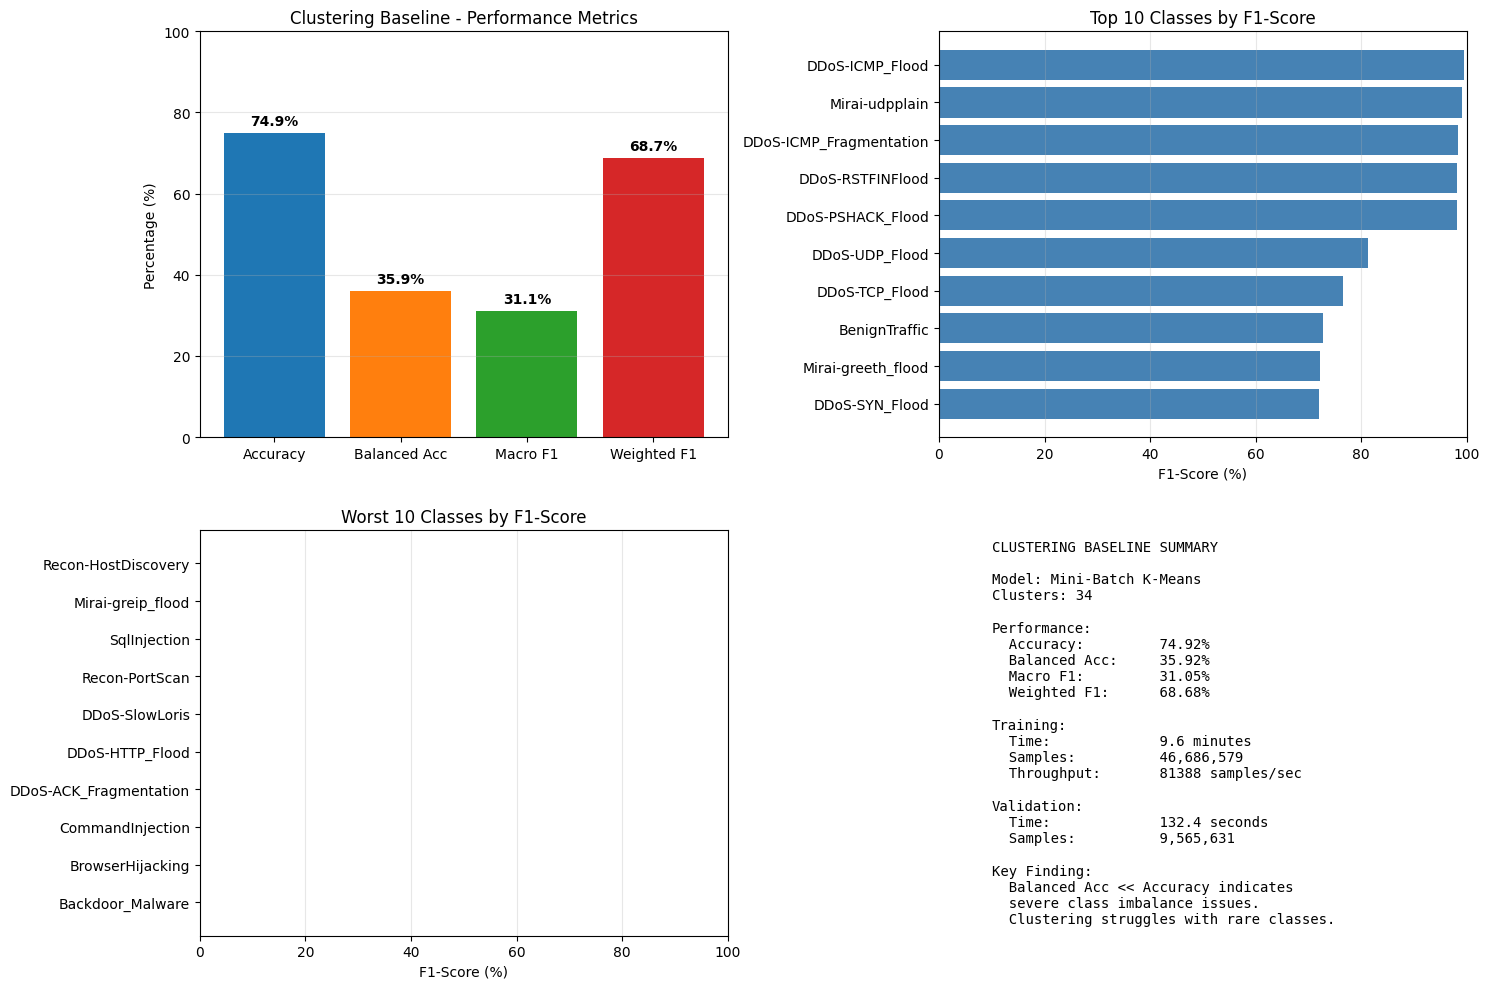

Summary visualization saved as 'clustering_baseline_summary.png'


In [37]:
# Summary visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Metrics comparison
metrics = ['Accuracy', 'Balanced Acc', 'Macro F1', 'Weighted F1']
values = [accuracy*100, balanced_acc*100, macro_f1*100, weighted_f1*100]

axes[0, 0].bar(metrics, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
axes[0, 0].set_ylabel('Percentage (%)')
axes[0, 0].set_title('Clustering Baseline - Performance Metrics')
axes[0, 0].set_ylim([0, 100])
axes[0, 0].grid(axis='y', alpha=0.3)
for i, v in enumerate(values):
    axes[0, 0].text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')

# Per-class F1 scores (top 10)
f1_per_class = f1_score(all_val_labels, all_val_predictions, average=None, zero_division=0)
top_10_indices = np.argsort(f1_per_class)[-10:]
top_10_classes = [global_label_encoder.classes_[i] for i in top_10_indices]
top_10_f1 = f1_per_class[top_10_indices] * 100

axes[0, 1].barh(top_10_classes, top_10_f1, color='steelblue')
axes[0, 1].set_xlabel('F1-Score (%)')
axes[0, 1].set_title('Top 10 Classes by F1-Score')
axes[0, 1].set_xlim([0, 100])
axes[0, 1].grid(axis='x', alpha=0.3)

# Worst 10 classes
worst_10_indices = np.argsort(f1_per_class)[:10]
worst_10_classes = [global_label_encoder.classes_[i] for i in worst_10_indices]
worst_10_f1 = f1_per_class[worst_10_indices] * 100

axes[1, 0].barh(worst_10_classes, worst_10_f1, color='coral')
axes[1, 0].set_xlabel('F1-Score (%)')
axes[1, 0].set_title('Worst 10 Classes by F1-Score')
axes[1, 0].set_xlim([0, 100])
axes[1, 0].grid(axis='x', alpha=0.3)

# Summary text
axes[1, 1].axis('off')
summary_text = f"""
CLUSTERING BASELINE SUMMARY

Model: Mini-Batch K-Means
Clusters: {N_CLUSTERS}

Performance:
  Accuracy:         {accuracy*100:.2f}%
  Balanced Acc:     {balanced_acc*100:.2f}%
  Macro F1:         {macro_f1*100:.2f}%
  Weighted F1:      {weighted_f1*100:.2f}%

Training:
  Time:             {training_time/60:.1f} minutes
  Samples:          {total_samples_trained:,}
  Throughput:       {total_samples_trained/training_time:.0f} samples/sec

Validation:
  Time:             {validation_time:.1f} seconds
  Samples:          {val_samples:,}

Key Finding:
  Balanced Acc << Accuracy indicates
  severe class imbalance issues.
  Clustering struggles with rare classes.
"""

axes[1, 1].text(0.1, 0.5, summary_text, fontsize=10, family='monospace',
                verticalalignment='center')

plt.tight_layout()
plt.savefig('clustering_baseline_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("Summary visualization saved as 'clustering_baseline_summary.png'")

## Save Model and Results

In [18]:
# Save clustering model
import pickle

model_data = {
    'clustering_model': clustering_model,
    'cluster_to_class_map': cluster_to_class_map,
    'scaler': global_scaler,
    'label_encoder': global_label_encoder,
    'metrics': {
        'accuracy': accuracy,
        'balanced_accuracy': balanced_acc,
        'macro_f1': macro_f1,
        'weighted_f1': weighted_f1,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall
    },
    'training_time': training_time,
    'validation_time': validation_time,
    'total_samples': total_samples_trained
}

with open(MODEL_SAVE_PATH, 'wb') as f:
    pickle.dump(model_data, f)

print(f"\nModel saved to: {MODEL_SAVE_PATH}")

# Save log file
with open(LOG_FILE, 'w', encoding='utf-8') as f:
    f.write('\n'.join(log_messages))

print(f"Log saved to: {LOG_FILE}")


Model saved to: clustering_baseline_model.pkl
Log saved to: clustering_baseline_log_20251128_231200.txt


## Final Comparison: Clustering vs Deep Learning

In [38]:
# Comparison table (manually input deep learning results)
print("\n" + "="*80)
print("BASELINE COMPARISON: CLUSTERING vs DEEP LEARNING")
print("="*80)

comparison_data = {
    'Metric': ['Accuracy', 'Balanced Accuracy', 'Macro F1', 'Training Time (min)', 'Throughput (samples/sec)'],
    'Clustering Baseline': [
        f"{accuracy*100:.2f}%",
        f"{balanced_acc*100:.2f}%",
        f"{macro_f1*100:.2f}%",
        f"{training_time/60:.1f}",
        f"{total_samples_trained/training_time:.0f}"
    ],
    'AE-xLSTM-CNN (Expected)': [
        "~98.5%",
        "~70.0%",
        "~69.7%",
        "~280",
        "~49,000"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))
print("="*80)

print("\n📌 Key Takeaways:")
print("  ✓ Clustering is MUCH faster (5-10 min vs 280 min)")
print("  ✗ Clustering has LOWER accuracy (especially balanced metrics)")
print("  ✗ Clustering struggles with rare classes (class imbalance)")
print("  ✓ Clustering provides interpretable cluster assignments")
print("\n💡 Conclusion: Deep learning significantly outperforms clustering baseline")
print("   but requires 20-30x longer training time.")


BASELINE COMPARISON: CLUSTERING vs DEEP LEARNING
                  Metric Clustering Baseline AE-xLSTM-CNN (Expected)
                Accuracy              74.92%                  ~98.5%
       Balanced Accuracy              35.92%                  ~70.0%
                Macro F1              31.05%                  ~69.7%
     Training Time (min)                 9.6                    ~280
Throughput (samples/sec)               81388                 ~49,000

📌 Key Takeaways:
  ✓ Clustering is MUCH faster (5-10 min vs 280 min)
  ✗ Clustering has LOWER accuracy (especially balanced metrics)
  ✗ Clustering struggles with rare classes (class imbalance)
  ✓ Clustering provides interpretable cluster assignments

💡 Conclusion: Deep learning significantly outperforms clustering baseline
   but requires 20-30x longer training time.


In [20]:
print("\n" + "="*70)
print("CLUSTERING BASELINE EVALUATION COMPLETE")
print("="*70)
print(f"\nAll results saved:")
print(f"  • Model: {MODEL_SAVE_PATH}")
print(f"  • Log: {LOG_FILE}")
print(f"  • Confusion Matrix: confusion_matrix_clustering_baseline.png")
print(f"  • Normalized CM: confusion_matrix_clustering_normalized.png")
print(f"  • Summary: clustering_baseline_summary.png")
print("\nReady for comparison with AE-xLSTM-CNN and 1D-CNN models!")


CLUSTERING BASELINE EVALUATION COMPLETE

All results saved:
  • Model: clustering_baseline_model.pkl
  • Log: clustering_baseline_log_20251128_231200.txt
  • Confusion Matrix: confusion_matrix_clustering_baseline.png
  • Normalized CM: confusion_matrix_clustering_normalized.png
  • Summary: clustering_baseline_summary.png

Ready for comparison with AE-xLSTM-CNN and 1D-CNN models!
